In [1]:
import pandas as pd
import numpy as np
import os

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns
### sns.set_style('darkgrid')

# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

# # scikit-learn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer, make_column_transformer
# from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Function for creating model pipelines - imblearn
from imblearn.pipeline import make_pipeline as imbl_pipe

# # Over-sampling using SMOTE
# from imblearn.over_sampling import SMOTE

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn import tree

import xgboost as xgb

import joblib
from tensorflow.keras.models import load_model

C:\Users\aaronlin\.conda\envs\project_churn.prediction\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\aaronlin\.conda\envs\project_churn.prediction\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\aaronlin\.conda\envs\project_churn.prediction\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\aaronli

In [47]:
df = pd.read_csv('Churn_Modelling.csv')
df =df.drop(columns=['RowNumber','CustomerId','Surname'])
print(f"Dataframe dimensions: {df.shape}")
df.head()

Dataframe dimensions: (10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [48]:
# Object for target variable
y = df.Exited

# object for input features
X = df.drop(['Exited'], axis=1)

# display shapes of X and y
print(X.shape, y.shape)

(10000, 10) (10000,)


In [49]:
random_state = 1


#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    #random_state=random_state,
                                                   #stratify=df.Exited)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size =0.7, random_state = 1)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

7000 3000 7000 3000


In [50]:
dt_model = joblib.load('Models/decision_tree.sav')
#dl_model = joblib.load('Models/deep_learning.sav')
#dl_model.named_steps['kerasclassifier'].model = load_model('models/keras_model.h5')
knn_model = joblib.load('Models/knn.sav')
lr_model = joblib.load('Models/logistic_regression.sav')
rf_model = joblib.load('Models/random_forest.sav')
svm_model = joblib.load('Models/SVM.sav')
xgb_model = joblib.load('Models/XGBoost.sav')

In [51]:
# Create models dictionary, it will be needed for ploting
models = {
    'dt' : 'Decision Tree',
    #'dl': 'Deep Learning',
    'knn' : 'K-nearest Neighbors',
    'lr' : 'Logistic Regression',
    'rf' : 'Random Forest',
    'svm' : 'Support Vector Machine (SVM)',
    'xgb' : 'XGBoost'
}

In [52]:
# Dictionary of all loaded models
loaded_models = {
    'dt' : dt_model,
    #'dl': dl_model,
    'knn': knn_model,
    'lr' : lr_model,
    'rf' : rf_model,
    'svm' : svm_model,
    'xgb' : xgb_model
}

In [53]:
target_names = ['Stays', 'Exits']


In [54]:
def evaluation(fit_models):
    lst = []
    for name, model in fit_models.items():
        pred = model.predict(X_test)
        lst.append([name, 
                    precision_score(y_test, pred, average='macro'),
                    recall_score(y_test, pred, average='macro'),
                    f1_score(y_test, pred, average='macro'),
                    accuracy_score(y_test, pred)])

    eval_df = pd.DataFrame(lst, columns=['model', 'precision', 'recall', 'f1_macro', 'accuracy'])
    eval_df.set_index('model', inplace = True)
    return eval_df

In [55]:
def class_rep_cm(fit_models, models, model_id):
    # Predict classes using model_id
    pred = fit_models[model_id].predict(X_test)
    print()
    print('\t', models[model_id])
    print('\t', '='*len(models[model_id]))

    # Display confusion matrix for y_test and pred
    conf_df = pd.DataFrame(confusion_matrix(y_test, pred), columns=target_names, index=target_names)
    conf_df.index.name = 'True Labels'
    conf_df = conf_df.rename_axis('Predicted Labels', axis='columns')
    display(conf_df)
    
    # Display classification report
    print()
    print(classification_report(y_test, pred, target_names=target_names))

In [56]:
def plot_conf_mat_w_and_wo_norm(fit_models, models, model_id, color):
    # Plot confusion matrix heatmaps
    pred = fit_models[model_id].predict(X_test)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    f.suptitle(models[model_id], fontsize=14)
    f.subplots_adjust(top=0.85, wspace=0.3)

    # confusion matrix without normalization
    mat = confusion_matrix(y_test, pred)
    sns.heatmap(mat,
                annot=True,
                annot_kws=dict(fontsize=14),
                fmt='d',
                cbar=True,
                square=True,
                cmap=color,
                ax=ax1)

    ax1.set_xticklabels(labels=target_names)
    ax1.set_yticklabels(labels=target_names, va='center')
    ax1.set_title('Confusion Matrix w/o Normalization')
    ax1.set_xlabel('Predicted Label', size=12)
    ax1.set_ylabel('True Label', size=12)

    # normalized confusion matrix
    matn = mat / mat.sum(axis=1)[:, np.newaxis]
    sns.heatmap(matn,
                annot=True,
                annot_kws=dict(fontsize=14),
                fmt='.2f',
                cbar=True,
                square=True,
                cmap=color,
                vmin = 0,
                vmax = 1,
                ax=ax2)

    ax2.set_xticklabels(labels=target_names)
    ax2.set_yticklabels(labels=target_names, va='center')
    ax2.set_title('Normalized Confusion Matrix')
    ax2.set_xlabel('Predicted Label', size=12)
    ax2.set_ylabel('True Label', size=12)

    plt.show()

In [57]:
def plot_norm_conf_matrices(fit_models, models, color):
    # Prepare lists of coordinates for axes
    lt = []  # list for full subplots
    ltd = []  # list for empty subplots
    col = 2  # number of columns
    n_mod = len(fit_models)  # number of fitted models
    
    # Number of rows
    row = - (n_mod // -col)
    
    # Create lists of coordinates for full and empty subplots
    for r in range(row):
        for c in range(col):
            if n_mod >= (r + 1) * (c + 1):
                lt.append([r, c])
            else:
                ltd.append([r, c])
    
    # Create figure and subplots
    figs_y = row * 4  # y size
    f, axs = plt.subplots(row, col, figsize=(10, figs_y))
    f.suptitle('Normalized Confusion Matrices', fontsize=14)
    f.subplots_adjust(top=0.94, wspace=0.90, hspace=0.2)
    
    # Reshape axes; needed in case of only 1 row
    axs = axs.reshape(row,-col)

    # Loop to delete N last empty subplots (if any)
    for n in range(len(ltd)):
        r = ltd[n][0]
        c = ltd[n][1]
        f.delaxes(ax= axs[r, c])
        
    # Loop to plot all full subplots
    i = 0
    # Loop for each fitted model        
    for id, model in fit_models.items():
        pred = model.predict(X_test)
        name = models[id]
        r = lt[i][0]
        c = lt[i][1]
        i += 1
     
        mat = confusion_matrix(y_test, pred)    
        # normalized confusion matrix
        matn = mat / mat.sum(axis=1)[:, np.newaxis]

        ax = axs[r, c]
        sns.heatmap(matn,
                    annot=True,
                    annot_kws=dict(fontsize=14),
                    fmt='.2f',
                    cbar=False,
                    square=True,
                    cmap=color,
                    vmin = 0,
                    vmax = 1,
                    #cbar_kws = {'shrink' : 0.85},
                    ax=ax)
    
        ax.set_xticklabels(labels=target_names)
        ax.set_yticklabels(labels=target_names, va='center')
        ax.set_title(name)
        ax.set_xlabel('Predicted Label', size=12)
        ax.set_ylabel('True Label', size=12)

    plt.show()

In [58]:
# Display evaluation metrics
evaluation(loaded_models)

,precision,recall,f1_macro,accuracy
model,,,,
dt,0.716262,0.769348,0.733422,0.800333
knn,0.640113,0.624189,0.630720,0.769333
lr,0.655495,0.711861,0.664162,0.731667
rf,0.764278,0.754494,0.759169,0.843667
svm,0.706310,0.764696,0.722996,0.788333
xgb,0.799574,0.754889,0.773442,0.861000


In [59]:
for model in models.keys():
    class_rep_cm(loaded_models, models, model)


	 Decision Tree


Predicted Labels,Stays,Exits
True Labels,,
Stays,1952,421
Exits,178,449



              precision    recall  f1-score   support

       Stays       0.92      0.82      0.87      2373
       Exits       0.52      0.72      0.60       627

    accuracy                           0.80      3000
   macro avg       0.72      0.77      0.73      3000
weighted avg       0.83      0.80      0.81      3000


	 K-nearest Neighbors


Predicted Labels,Stays,Exits
True Labels,,
Stays,2073,300
Exits,392,235



              precision    recall  f1-score   support

       Stays       0.84      0.87      0.86      2373
       Exits       0.44      0.37      0.40       627

    accuracy                           0.77      3000
   macro avg       0.64      0.62      0.63      3000
weighted avg       0.76      0.77      0.76      3000


	 Logistic Regression


Predicted Labels,Stays,Exits
True Labels,,
Stays,1770,603
Exits,202,425



              precision    recall  f1-score   support

       Stays       0.90      0.75      0.81      2373
       Exits       0.41      0.68      0.51       627

    accuracy                           0.73      3000
   macro avg       0.66      0.71      0.66      3000
weighted avg       0.80      0.73      0.75      3000


	 Random Forest


Predicted Labels,Stays,Exits
True Labels,,
Stays,2154,219
Exits,250,377



              precision    recall  f1-score   support

       Stays       0.90      0.91      0.90      2373
       Exits       0.63      0.60      0.62       627

    accuracy                           0.84      3000
   macro avg       0.76      0.75      0.76      3000
weighted avg       0.84      0.84      0.84      3000


	 Support Vector Machine (SVM)


Predicted Labels,Stays,Exits
True Labels,,
Stays,1911,462
Exits,173,454



              precision    recall  f1-score   support

       Stays       0.92      0.81      0.86      2373
       Exits       0.50      0.72      0.59       627

    accuracy                           0.79      3000
   macro avg       0.71      0.76      0.72      3000
weighted avg       0.83      0.79      0.80      3000


	 XGBoost


Predicted Labels,Stays,Exits
True Labels,,
Stays,2224,149
Exits,268,359



              precision    recall  f1-score   support

       Stays       0.89      0.94      0.91      2373
       Exits       0.71      0.57      0.63       627

    accuracy                           0.86      3000
   macro avg       0.80      0.75      0.77      3000
weighted avg       0.85      0.86      0.86      3000



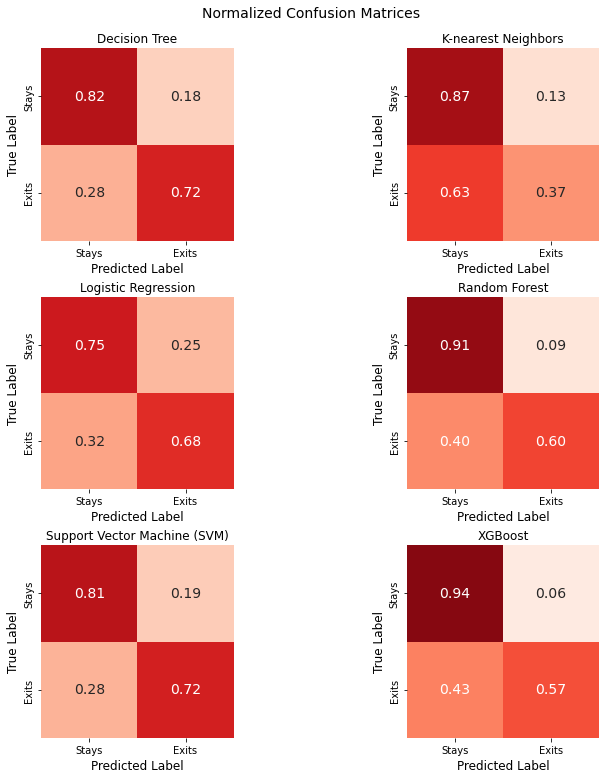

In [60]:
# Plot all confusion matrices 
plot_norm_conf_matrices(loaded_models, models, 'Reds')